In [5]:
import os
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
from xgboost import XGBRegressor
import optuna
import warnings
warnings.filterwarnings('ignore')

# Financial indicators to forecast
financial_indicators = [
    '1_year_rate', '3_months_rate', '6_months_rate', 'CPI', 'INDPRO',
    '10_year_rate', 'share_price', 'unemployment_rate', 'PPI',
    'OECD_CLI_index', 'CSI_index', 'gdp_per_capita'
]

# Recession probability target columns to exclude from features
recession_targets = [
    'recession_probability', '1_month_recession_probability',
    '3_month_recession_probability', '6_month_recession_probability'
]

def prepare_existing_features(train_df, test_df, target_indicator):
    """Prepare existing features from train and test dataframes, excluding recession targets"""
    print(f"\nPreparing existing features for {target_indicator}...")
    
    # Define features to exclude (date, target, and recession targets)
    features_to_exclude = ['date'] + recession_targets + [target_indicator]
    
    # Get available features from training data
    available_features = [c for c in train_df.columns if c not in features_to_exclude]
    
    print(f"Available existing features: {len(available_features)}")
    print(f"Features: {available_features[:10]}..." if len(available_features) > 10 else f"Features: {available_features}")
    
    # Ensure test data has the same features
    common_features = [f for f in available_features if f in test_df.columns]
    
    if len(common_features) != len(available_features):
        missing_in_test = set(available_features) - set(common_features)
        print(f"Warning: {len(missing_in_test)} features missing in test data: {missing_in_test}")
    
    train_features = train_df[common_features].copy()
    test_features = test_df[common_features].copy()
    
    return train_features, test_features, common_features

def clean_existing_features(train_features, test_features, feature_cols):
    """Clean existing feature data"""
    print(f"Cleaning existing feature data...")
    print(f"  Initial shapes - Train: {train_features.shape}, Test: {test_features.shape}")
    
    # Handle infinite values and NaNs
    for col in feature_cols:
        if col in train_features.columns:
            # Clean training features
            train_features[col] = train_features[col].replace([np.inf, -np.inf], np.nan)
            train_features[col] = train_features[col].fillna(method='ffill').fillna(method='bfill')
            if train_features[col].isna().any():
                train_features[col] = train_features[col].fillna(train_features[col].median())
            if train_features[col].isna().any():
                train_features[col] = train_features[col].fillna(0)
        
        if col in test_features.columns:
            # Clean test features
            test_features[col] = test_features[col].replace([np.inf, -np.inf], np.nan)
            test_features[col] = test_features[col].fillna(method='ffill').fillna(method='bfill')
            if test_features[col].isna().any():
                # Use training median for consistency
                fill_value = train_features[col].median() if col in train_features.columns else 0
                test_features[col] = test_features[col].fillna(fill_value)
            if test_features[col].isna().any():
                test_features[col] = test_features[col].fillna(0)
    
    # Remove columns with no variation in training data
    varying_cols = []
    for col in feature_cols:
        if col in train_features.columns and train_features[col].nunique() > 1:
            varying_cols.append(col)
    
    # Keep only varying columns in both datasets
    train_features_clean = train_features[varying_cols]
    test_features_clean = test_features[[c for c in varying_cols if c in test_features.columns]]
    
    print(f"  Final shapes - Train: {train_features_clean.shape}, Test: {test_features_clean.shape}")
    print(f"  Features with variation: {len(varying_cols)}")
    print(f"  Remaining missing values - Train: {train_features_clean.isnull().sum().sum()}, Test: {test_features_clean.isnull().sum().sum()}")
    
    return train_features_clean, test_features_clean, varying_cols

def make_xgb_objective(X_train, y_train, X_val, y_val, random_state=42):
    """Create Optuna objective function for XGBoost hyperparameter tuning"""
    def objective(trial):
        params = {
            "n_estimators": trial.suggest_int("n_estimators", 200, 2000),
            "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
            "max_depth": trial.suggest_int("max_depth", 2, 8),
            "min_child_weight": trial.suggest_float("min_child_weight", 1.0, 10.0),
            "subsample": trial.suggest_float("subsample", 0.6, 1.0),
            "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
            "gamma": trial.suggest_float("gamma", 0.0, 5.0),
            "reg_alpha": trial.suggest_float("reg_alpha", 0.0, 5.0),
            "reg_lambda": trial.suggest_float("reg_lambda", 0.5, 5.0),
            "random_state": random_state,
            "objective": "reg:squarederror",
            "tree_method": "hist",
        }
        model = XGBRegressor(**params)
        
        # Use the new validation approach instead of early_stopping_rounds in fit()
        model.fit(X_train, y_train)
        preds = model.predict(X_val)
        rmse = np.sqrt(mean_squared_error(y_val, preds))
        return rmse
    return objective

def make_xgb_objective_with_early_stopping(X_train, y_train, X_val, y_val, random_state=42):
    """Create Optuna objective function with proper early stopping for newer XGBoost versions"""
    def objective(trial):
        params = {
            "n_estimators": trial.suggest_int("n_estimators", 200, 2000),
            "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
            "max_depth": trial.suggest_int("max_depth", 2, 8),
            "min_child_weight": trial.suggest_float("min_child_weight", 1.0, 10.0),
            "subsample": trial.suggest_float("subsample", 0.6, 1.0),
            "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
            "gamma": trial.suggest_float("gamma", 0.0, 5.0),
            "reg_alpha": trial.suggest_float("reg_alpha", 0.0, 5.0),
            "reg_lambda": trial.suggest_float("reg_lambda", 0.5, 5.0),
            "random_state": random_state,
            "objective": "reg:squarederror",
            "tree_method": "hist",
            "early_stopping_rounds": 100,  # Set as parameter instead of in fit()
            "eval_metric": "rmse"
        }
        
        try:
            model = XGBRegressor(**params)
            # Try new style first
            model.fit(
                X_train, y_train,
                eval_set=[(X_val, y_val)],
                verbose=False
            )
        except TypeError:
            # Fall back to old style without early stopping in fit
            params.pop('early_stopping_rounds', None)
            params.pop('eval_metric', None)
            model = XGBRegressor(**params)
            model.fit(X_train, y_train)
        
        preds = model.predict(X_val)
        rmse = np.sqrt(mean_squared_error(y_val, preds))
        return rmse
    return objective

def time_val_split(X, y, val_ratio=0.2):
    """Keep order; last portion as validation."""
    n = len(X)
    cut = int(np.floor(n * (1 - val_ratio)))
    return X[:cut], X[cut:], y[:cut], y[cut:]

def forecast_indicator_with_xgb(train_df, test_df, indicator, n_trials=50):
    """Forecast indicator using XGBoost with existing features only"""
    print(f"\n{'='*60}\nFORECASTING: {indicator}\n{'='*60}")
    
    if indicator not in train_df.columns or indicator not in test_df.columns:
        print(f"ERROR: {indicator} not in datasets")
        return None
    
    # Get target series
    train_series = train_df[indicator].dropna()
    test_series = test_df[indicator].dropna()
    print(f"Series lengths - Train: {len(train_series)}, Test: {len(test_series)}")
    
    if len(train_series) < 10:
        print(f"ERROR: Insufficient training data for {indicator}")
        return None
    
    # Prepare existing features
    try:
        train_features, test_features, available_features = prepare_existing_features(train_df, test_df, indicator)
        train_features_clean, test_features_clean, feature_cols = clean_existing_features(train_features, test_features, available_features)
        
        if len(feature_cols) == 0:
            print(f"WARNING: No features available for {indicator}")
            return None
            
    except Exception as e:
        print(f"ERROR preparing features: {e}")
        return None
    
    # Align features with target series (handle any index mismatches)
    train_features_aligned = train_features_clean.loc[train_series.index]
    test_features_aligned = test_features_clean.loc[test_series.index]
    
    # Remove any remaining NaN rows
    train_mask = ~(train_series.isna() | train_features_aligned.isna().any(axis=1))
    test_mask = ~(test_series.isna() | test_features_aligned.isna().any(axis=1))
    
    X_train_full = train_features_aligned.loc[train_mask].values
    y_train_full = train_series.loc[train_mask].values
    X_test = test_features_aligned.loc[test_mask].values
    y_test = test_series.loc[test_mask].values
    
    if len(X_train_full) < 10:
        print(f"ERROR: Insufficient clean training data for {indicator}: {len(X_train_full)} rows")
        return None
    
    print(f"Clean data shapes - Train: {X_train_full.shape}, Test: {X_test.shape}")
    print(f"Using {len(feature_cols)} features")
    
    # Split training data for hyperparameter tuning
    X_train, X_val, y_train, y_val = time_val_split(X_train_full, y_train_full)
    
    # Hyperparameter tuning with Optuna
    print(f"\nRunning XGBoost hyperparameter optimization...")
    print(f"Training shape: {X_train.shape}, Validation shape: {X_val.shape}")
    
    try:
        study = optuna.create_study(direction="minimize")
        study.optimize(
            make_xgb_objective(X_train, y_train, X_val, y_val, random_state=42), 
            n_trials=n_trials, 
            show_progress_bar=False
        )
        
        best_params = study.best_params
        print(f"Best parameters: {best_params}")
        print(f"Best validation RMSE: {study.best_value:.4f}")
        
        # Train final model on full training data
        X_train_final, X_val_final, y_train_final, y_val_final = time_val_split(X_train_full, y_train_full)
        
        # Try to use early stopping if supported
        final_params = {
            **{k: v for k, v in best_params.items() if k != "random_state"},
            "random_state": 42,
            "objective": "reg:squarederror",
            "tree_method": "hist"
        }
        
        final_model = XGBRegressor(**final_params)
        
        # Try with early stopping first, fall back if not supported
        try:
            final_model.fit(
                X_train_final, y_train_final,
                eval_set=[(X_val_final, y_val_final)],
                verbose=False
            )
            print("Using validation set for model training")
        except (TypeError, AttributeError):
            # Fall back to simple training without early stopping
            final_model.fit(X_train_full, y_train_full)
            print("Using simple training without early stopping")
        
        # Make predictions on test data
        forecast = final_model.predict(X_test)
        
        # Calculate metrics
        mae = mean_absolute_error(y_test, forecast)
        rmse = np.sqrt(mean_squared_error(y_test, forecast))
        
        # Calculate MAPE with mask for non-zero values
        mask = y_test != 0
        mape = np.mean(np.abs((y_test[mask] - forecast[mask]) / y_test[mask])) * 100 if mask.any() else np.inf
        
        print(f"\nAccuracy Metrics:\n  MAE: {mae:.4f}\n  RMSE: {rmse:.4f}\n  MAPE: {mape:.2f}%")
        
        # Save model
        os.makedirs("xgb_models", exist_ok=True)
        with open(f"xgb_models/{indicator}_xgb_model.pkl", "wb") as f:
            pickle.dump(final_model, f)
        print(f"Model saved to xgb_models/{indicator}_xgb_model.pkl")
        
        return {
            'model': final_model,
            'best_params': best_params,
            'best_val_rmse': study.best_value,
            'forecast': forecast,
            'actual': y_test,
            'mae': mae,
            'rmse': rmse,
            'mape': mape,
            'feature_cols': feature_cols,
            'train_length': len(y_train_full),
            'test_length': len(y_test),
            'train_dates': train_df.loc[train_series.loc[train_mask].index, 'date'].values,
            'test_dates': test_df.loc[test_series.loc[test_mask].index, 'date'].values
        }
        
    except Exception as e:
        print(f"ERROR training XGBoost for {indicator}: {e}")
        return None

def plot_xgb_forecast_results(results, indicator, train_df, test_df):
    """Plot XGBoost forecast results similar to ARIMA style"""
    if results is None:
        return
        
    plt.figure(figsize=(15, 8))
    
    # Plot training data (last portion for visibility)
    train_series = train_df[indicator].dropna()
    train_plot = train_series.tail(min(50, len(train_series)))
    train_dates = train_df.loc[train_plot.index, 'date']
    
    plt.plot(train_dates, train_plot.values, label='Training', color='blue', alpha=0.7)
    
    # Plot actual and forecast
    actual = results['actual']
    forecast = results['forecast']
    test_dates = results['test_dates']
    
    plt.plot(test_dates, actual, label='Actual', color='green', linewidth=2, marker='o', markersize=4)
    plt.plot(test_dates, forecast, label='Forecast', color='red', linewidth=2, marker='s', markersize=4)
    
    # Add title with metrics
    plt.title(f'{indicator} - XGBoost Forecast\n'
              f'MAE: {results["mae"]:.4f}, RMSE: {results["rmse"]:.4f}, MAPE: {results["mape"]:.2f}%',
              fontsize=14)
    
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.xticks(rotation=45)
    
    # Add vertical line to separate training and test
    if len(test_dates) > 0:
        plt.axvline(x=test_dates[0], color='gray', linestyle='--', alpha=0.7)
    
    plt.tight_layout()
    plt.show()

def run_xgb_forecasting_existing_features(train_df, test_df, financial_indicators=None, n_trials=40, plot_results=True):
    """Run XGBoost forecasting pipeline using existing features only"""
    print("=" * 80)
    print("XGBoost TIME SERIES FORECASTING - EXISTING FEATURES ONLY")
    print("=" * 80)
    
    if financial_indicators is None:
        financial_indicators = [
            '1_year_rate', '3_months_rate', '6_months_rate', 'CPI', 'INDPRO',
            '10_year_rate', 'share_price', 'unemployment_rate', 'PPI',
            'OECD_CLI_index', 'CSI_index', 'gdp_per_capita'
        ]
    
    train_work = train_df.copy()
    test_work = test_df.copy()
    train_work['date'] = pd.to_datetime(train_work['date'])
    test_work['date'] = pd.to_datetime(test_work['date'])
    
    # Check available indicators
    available = [i for i in financial_indicators if i in train_work.columns and i in test_work.columns]
    print(f"Indicators to forecast: {available}")
    print(f"Excluding recession features: {recession_targets}")
    
    all_results = {}
    forecasted = pd.DataFrame({'date': test_work['date'].copy()})
    
    for ind in available:
        res = forecast_indicator_with_xgb(
            train_work, test_work, ind, 
            n_trials=n_trials
        )
        
        if res:
            all_results[ind] = res
            
            # Add results to forecasted dataframe
            steps = len(res['forecast'])
            forecasted[f'{ind}_forecast'] = np.nan
            forecasted[f'{ind}_actual'] = np.nan
            
            # Find matching indices for test dates
            test_dates_df = pd.DataFrame({'date': pd.to_datetime(res['test_dates'])})
            merged = forecasted.merge(test_dates_df.reset_index(), on='date', how='left')
            valid_indices = merged.dropna()['index'].astype(int).values[:steps]
            
            if len(valid_indices) == len(res['forecast']):
                forecasted.loc[valid_indices, f'{ind}_forecast'] = res['forecast']
                forecasted.loc[valid_indices, f'{ind}_actual'] = res['actual']
            
            if plot_results:
                plot_xgb_forecast_results(res, ind, train_work, test_work)
    
    print(f"\n{'='*60}")
    print("FORECASTING COMPLETE")
    print(f"{'='*60}")
    print(f"Successfully forecasted {len(all_results)} indicators")
    
    # Print summary metrics
    if all_results:
        print(f"\nSUMMARY METRICS:")
        for ind, res in all_results.items():
            print(f"{ind:20s} - MAE: {res['mae']:.4f}, RMSE: {res['rmse']:.4f}, MAPE: {res['mape']:.2f}%")
    
    return all_results, forecasted

[I 2025-09-16 16:39:07,106] A new study created in memory with name: no-name-0cebcb27-995f-4c4a-81c4-54ccca54a45a


XGBoost TIME SERIES FORECASTING - EXISTING FEATURES ONLY
Indicators to forecast: ['1_year_rate', '3_months_rate', '6_months_rate', 'CPI', 'INDPRO', '10_year_rate', 'share_price', 'unemployment_rate', 'PPI', 'OECD_CLI_index', 'CSI_index', 'gdp_per_capita']
Excluding recession features: ['recession_probability', '1_month_recession_probability', '3_month_recession_probability', '6_month_recession_probability']

FORECASTING: 1_year_rate
Series lengths - Train: 556, Test: 65

Preparing existing features for 1_year_rate...
Available existing features: 29
Features: ['3_months_rate', '6_months_rate', 'CPI', 'INDPRO', '10_year_rate', 'share_price', 'unemployment_rate', 'PPI', 'OECD_CLI_index', 'CSI_index']...
Cleaning existing feature data...
  Initial shapes - Train: (635, 29), Test: (65, 29)
  Final shapes - Train: (635, 29), Test: (65, 29)
  Features with variation: 29
  Remaining missing values - Train: 0, Test: 0
Clean data shapes - Train: (556, 29), Test: (65, 29)
Using 29 features

Runni

[I 2025-09-16 16:39:08,116] Trial 0 finished with value: 0.5324177996729049 and parameters: {'n_estimators': 1956, 'learning_rate': 0.01242627214598364, 'max_depth': 8, 'min_child_weight': 6.473192102283887, 'subsample': 0.9903464426777815, 'colsample_bytree': 0.9399454132910474, 'gamma': 3.9503105845205013, 'reg_alpha': 0.17354077141791657, 'reg_lambda': 2.8098739225611653}. Best is trial 0 with value: 0.5324177996729049.
[I 2025-09-16 16:39:08,515] Trial 1 finished with value: 0.556190494182872 and parameters: {'n_estimators': 1321, 'learning_rate': 0.09351782404052951, 'max_depth': 5, 'min_child_weight': 5.290393949710883, 'subsample': 0.954115795813968, 'colsample_bytree': 0.9429839650276343, 'gamma': 2.077647728030583, 'reg_alpha': 4.022250252383344, 'reg_lambda': 0.6679187867979606}. Best is trial 0 with value: 0.5324177996729049.
[I 2025-09-16 16:39:08,714] Trial 2 finished with value: 0.4384398647019082 and parameters: {'n_estimators': 421, 'learning_rate': 0.13386827273593754,

Best parameters: {'n_estimators': 1344, 'learning_rate': 0.07204750019683467, 'max_depth': 2, 'min_child_weight': 6.994275207884568, 'subsample': 0.9996465260352144, 'colsample_bytree': 0.8074183696558359, 'gamma': 0.021889205519028315, 'reg_alpha': 0.43897619719524356, 'reg_lambda': 2.8039526117463742}
Best validation RMSE: 0.2659
Using validation set for model training

Accuracy Metrics:
  MAE: 0.5789
  RMSE: 0.6289
  MAPE: 157.60%
Model saved to xgb_models/1_year_rate_xgb_model.pkl


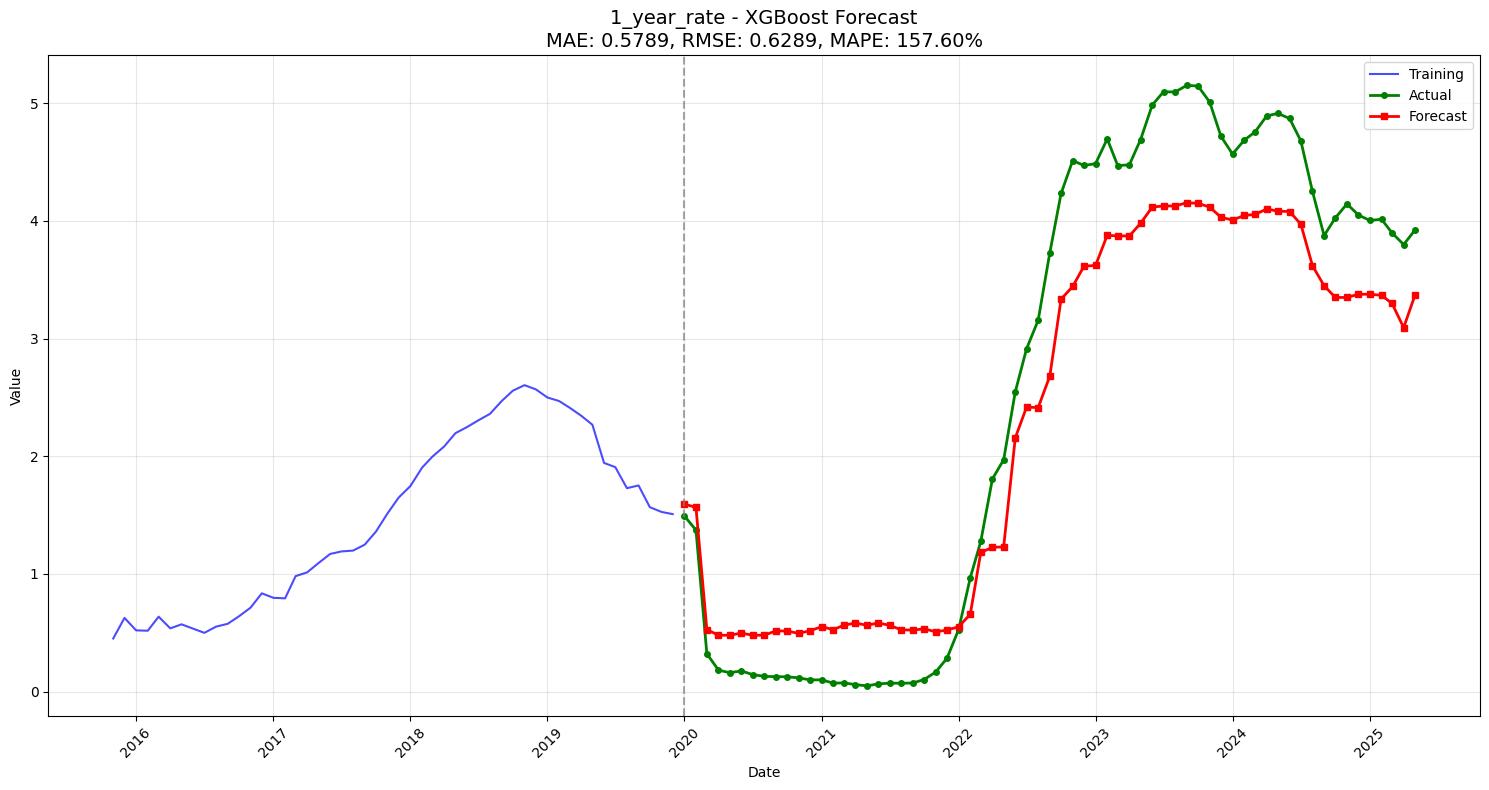

[I 2025-09-16 16:39:31,984] A new study created in memory with name: no-name-2c33aece-9ebe-41ef-a1b2-b560b8ff5513



FORECASTING: 3_months_rate
Series lengths - Train: 635, Test: 65

Preparing existing features for 3_months_rate...
Available existing features: 29
Features: ['1_year_rate', '6_months_rate', 'CPI', 'INDPRO', '10_year_rate', 'share_price', 'unemployment_rate', 'PPI', 'OECD_CLI_index', 'CSI_index']...
Cleaning existing feature data...
  Initial shapes - Train: (635, 29), Test: (65, 29)
  Final shapes - Train: (635, 29), Test: (65, 29)
  Features with variation: 29
  Remaining missing values - Train: 0, Test: 0
Clean data shapes - Train: (635, 29), Test: (65, 29)
Using 29 features

Running XGBoost hyperparameter optimization...
Training shape: (508, 29), Validation shape: (127, 29)


[I 2025-09-16 16:39:32,726] Trial 0 finished with value: 0.7928008706831942 and parameters: {'n_estimators': 1555, 'learning_rate': 0.05622487827563, 'max_depth': 5, 'min_child_weight': 8.983347743017397, 'subsample': 0.6650728803122267, 'colsample_bytree': 0.7868911898020288, 'gamma': 0.7076137918630027, 'reg_alpha': 2.4568166955347044, 'reg_lambda': 3.337716632316345}. Best is trial 0 with value: 0.7928008706831942.
[I 2025-09-16 16:39:33,461] Trial 1 finished with value: 0.942059773141539 and parameters: {'n_estimators': 1773, 'learning_rate': 0.06436271387906503, 'max_depth': 7, 'min_child_weight': 5.942345832415183, 'subsample': 0.7355005942810897, 'colsample_bytree': 0.7763178626736362, 'gamma': 4.299317204061907, 'reg_alpha': 1.8697177134299818, 'reg_lambda': 3.613648627249481}. Best is trial 0 with value: 0.7928008706831942.
[I 2025-09-16 16:39:34,098] Trial 2 finished with value: 0.9349191335313649 and parameters: {'n_estimators': 1723, 'learning_rate': 0.01418709329443631, 'm

Best parameters: {'n_estimators': 1371, 'learning_rate': 0.024522365625340506, 'max_depth': 8, 'min_child_weight': 2.883467699374148, 'subsample': 0.7181184814613985, 'colsample_bytree': 0.8713466533332586, 'gamma': 0.005214429671283443, 'reg_alpha': 0.32261705618090236, 'reg_lambda': 1.894729149706205}
Best validation RMSE: 0.3064
Using validation set for model training

Accuracy Metrics:
  MAE: 0.3745
  RMSE: 0.4358
  MAPE: 430.98%
Model saved to xgb_models/3_months_rate_xgb_model.pkl


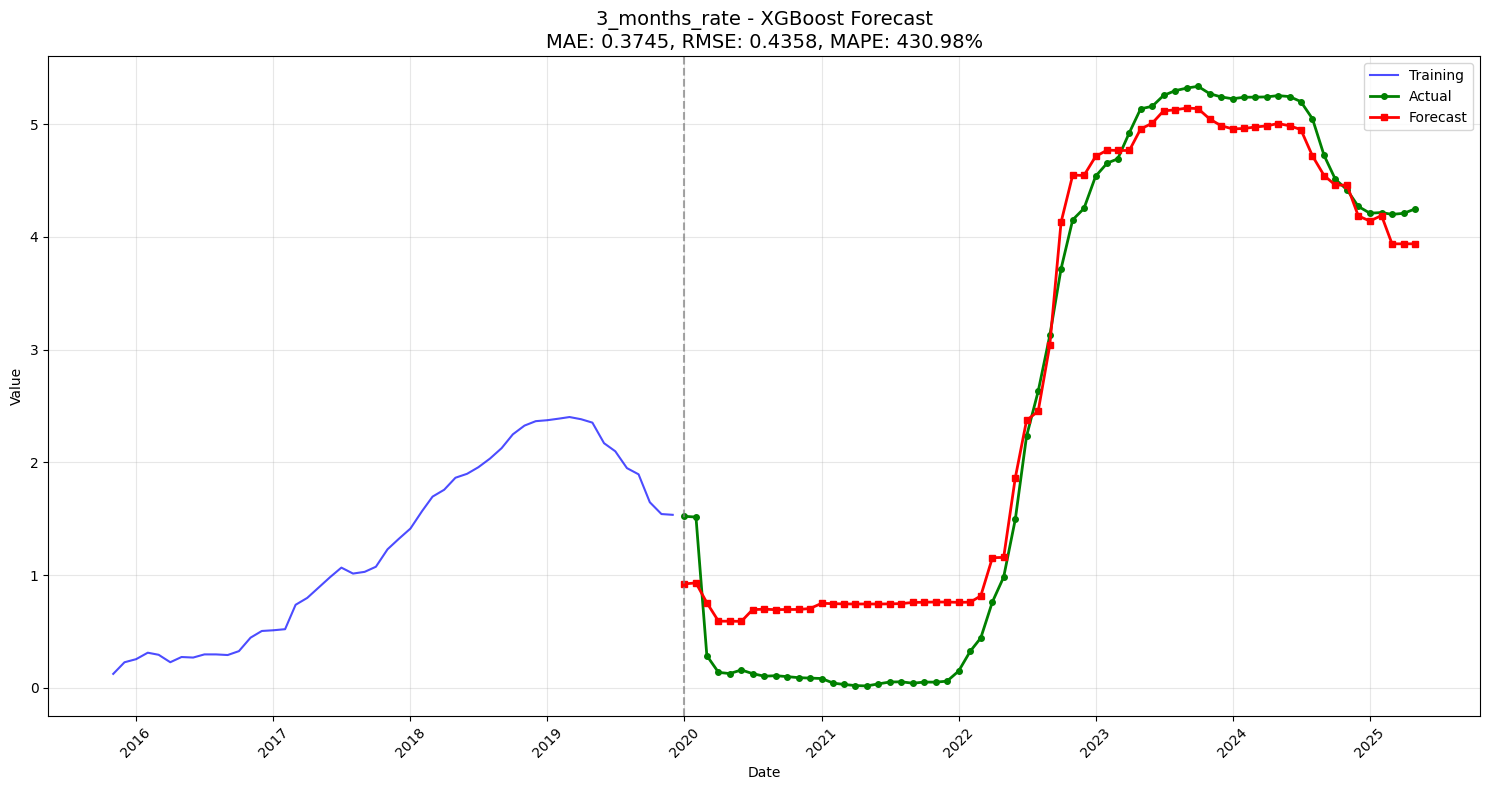

[I 2025-09-16 16:40:02,427] A new study created in memory with name: no-name-9344320d-ad2f-4557-a997-ceacb0027b37



FORECASTING: 6_months_rate
Series lengths - Train: 635, Test: 65

Preparing existing features for 6_months_rate...
Available existing features: 29
Features: ['1_year_rate', '3_months_rate', 'CPI', 'INDPRO', '10_year_rate', 'share_price', 'unemployment_rate', 'PPI', 'OECD_CLI_index', 'CSI_index']...
Cleaning existing feature data...
  Initial shapes - Train: (635, 29), Test: (65, 29)
  Final shapes - Train: (635, 29), Test: (65, 29)
  Features with variation: 29
  Remaining missing values - Train: 0, Test: 0
Clean data shapes - Train: (635, 29), Test: (65, 29)
Using 29 features

Running XGBoost hyperparameter optimization...
Training shape: (508, 29), Validation shape: (127, 29)


[I 2025-09-16 16:40:02,696] Trial 0 finished with value: 1.1364505780414227 and parameters: {'n_estimators': 638, 'learning_rate': 0.09956854501672614, 'max_depth': 8, 'min_child_weight': 8.538693357491226, 'subsample': 0.6217830212782259, 'colsample_bytree': 0.8666123839617783, 'gamma': 4.391149959853658, 'reg_alpha': 3.8562421592841396, 'reg_lambda': 4.604226707054269}. Best is trial 0 with value: 1.1364505780414227.
[I 2025-09-16 16:40:03,060] Trial 1 finished with value: 1.0152270288802256 and parameters: {'n_estimators': 744, 'learning_rate': 0.03834258048813795, 'max_depth': 5, 'min_child_weight': 8.498463210524296, 'subsample': 0.8820818867505067, 'colsample_bytree': 0.6476343992194835, 'gamma': 4.753019707421097, 'reg_alpha': 1.7199391974839906, 'reg_lambda': 1.6687526891347841}. Best is trial 1 with value: 1.0152270288802256.
[I 2025-09-16 16:40:03,380] Trial 2 finished with value: 0.9289950734197425 and parameters: {'n_estimators': 788, 'learning_rate': 0.20729377488282788, '

Best parameters: {'n_estimators': 920, 'learning_rate': 0.02375645327368554, 'max_depth': 4, 'min_child_weight': 5.8106850232442815, 'subsample': 0.8956173197883406, 'colsample_bytree': 0.8382175631173274, 'gamma': 0.31913600377834617, 'reg_alpha': 0.009856090133076693, 'reg_lambda': 0.5551676507048178}
Best validation RMSE: 0.4645
Using validation set for model training

Accuracy Metrics:
  MAE: 0.6267
  RMSE: 0.6885
  MAPE: 439.13%
Model saved to xgb_models/6_months_rate_xgb_model.pkl


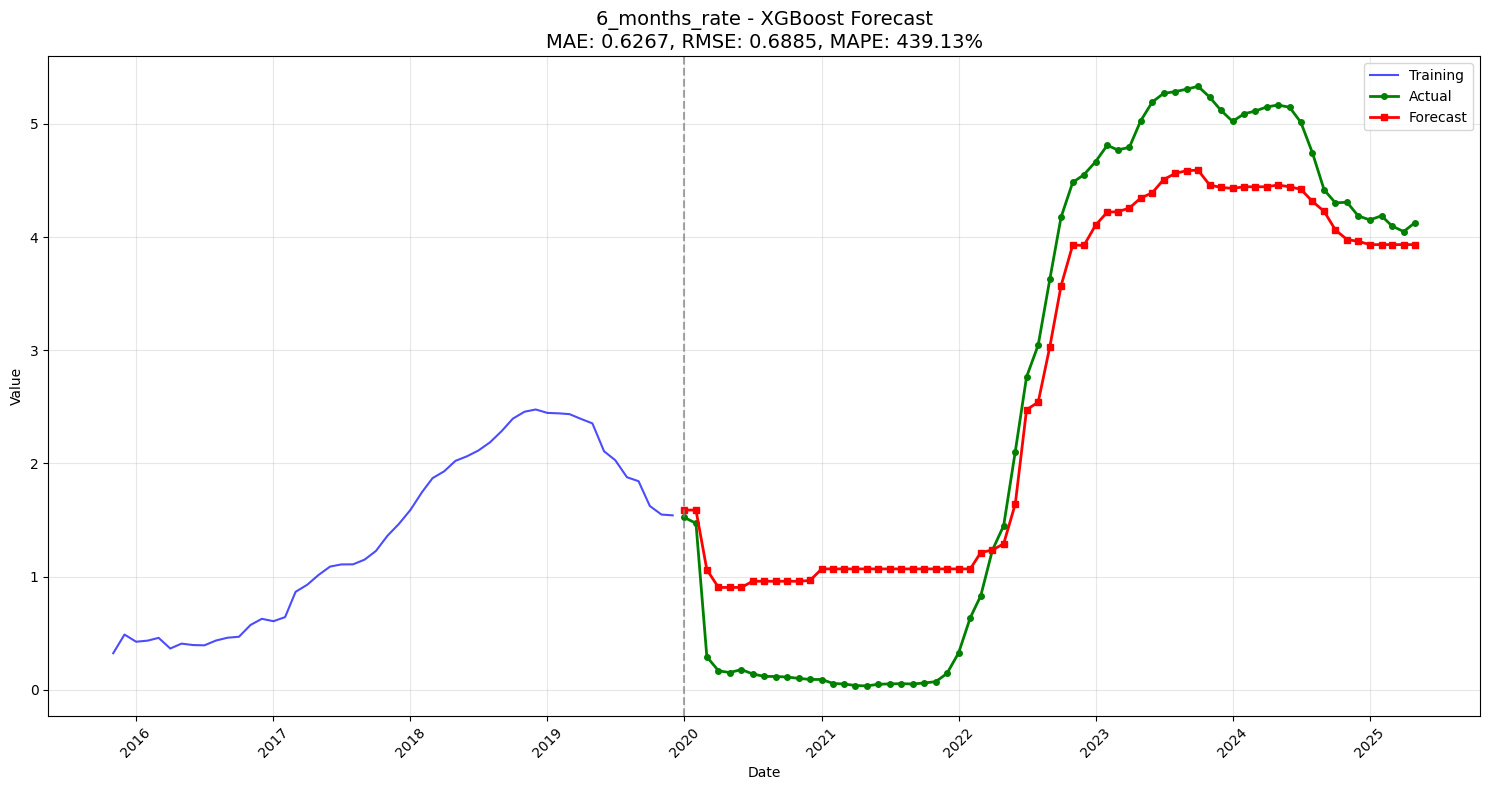

[I 2025-09-16 16:40:24,348] A new study created in memory with name: no-name-d68ec669-1591-4860-afd8-7de127ff9060



FORECASTING: CPI
Series lengths - Train: 635, Test: 65

Preparing existing features for CPI...
Available existing features: 29
Features: ['1_year_rate', '3_months_rate', '6_months_rate', 'INDPRO', '10_year_rate', 'share_price', 'unemployment_rate', 'PPI', 'OECD_CLI_index', 'CSI_index']...
Cleaning existing feature data...
  Initial shapes - Train: (635, 29), Test: (65, 29)
  Final shapes - Train: (635, 29), Test: (65, 29)
  Features with variation: 29
  Remaining missing values - Train: 0, Test: 0
Clean data shapes - Train: (635, 29), Test: (65, 29)
Using 29 features

Running XGBoost hyperparameter optimization...
Training shape: (508, 29), Validation shape: (127, 29)


[I 2025-09-16 16:40:25,470] Trial 0 finished with value: 28.00625438978525 and parameters: {'n_estimators': 1955, 'learning_rate': 0.03911020014432051, 'max_depth': 7, 'min_child_weight': 1.7114794141293588, 'subsample': 0.7756305519328222, 'colsample_bytree': 0.95079870799712, 'gamma': 0.16374135835788783, 'reg_alpha': 1.034309260861861, 'reg_lambda': 1.9338121419912055}. Best is trial 0 with value: 28.00625438978525.
[I 2025-09-16 16:40:26,039] Trial 1 finished with value: 29.246331484234904 and parameters: {'n_estimators': 403, 'learning_rate': 0.013369869841057907, 'max_depth': 5, 'min_child_weight': 8.731459464955151, 'subsample': 0.6879086947929524, 'colsample_bytree': 0.6966046523797401, 'gamma': 3.3966142520295195, 'reg_alpha': 3.998741062969768, 'reg_lambda': 4.1497757041266325}. Best is trial 0 with value: 28.00625438978525.
[I 2025-09-16 16:40:26,269] Trial 2 finished with value: 24.596070048418984 and parameters: {'n_estimators': 453, 'learning_rate': 0.200699129415161, 'ma

Best parameters: {'n_estimators': 453, 'learning_rate': 0.200699129415161, 'max_depth': 5, 'min_child_weight': 3.323384914422685, 'subsample': 0.9584663752559435, 'colsample_bytree': 0.8712006763038134, 'gamma': 2.1489094006342393, 'reg_alpha': 2.016789517499378, 'reg_lambda': 4.512102002646879}
Best validation RMSE: 24.5961
Using validation set for model training

Accuracy Metrics:
  MAE: 74.7934
  RMSE: 77.9732
  MAPE: 25.30%
Model saved to xgb_models/CPI_xgb_model.pkl


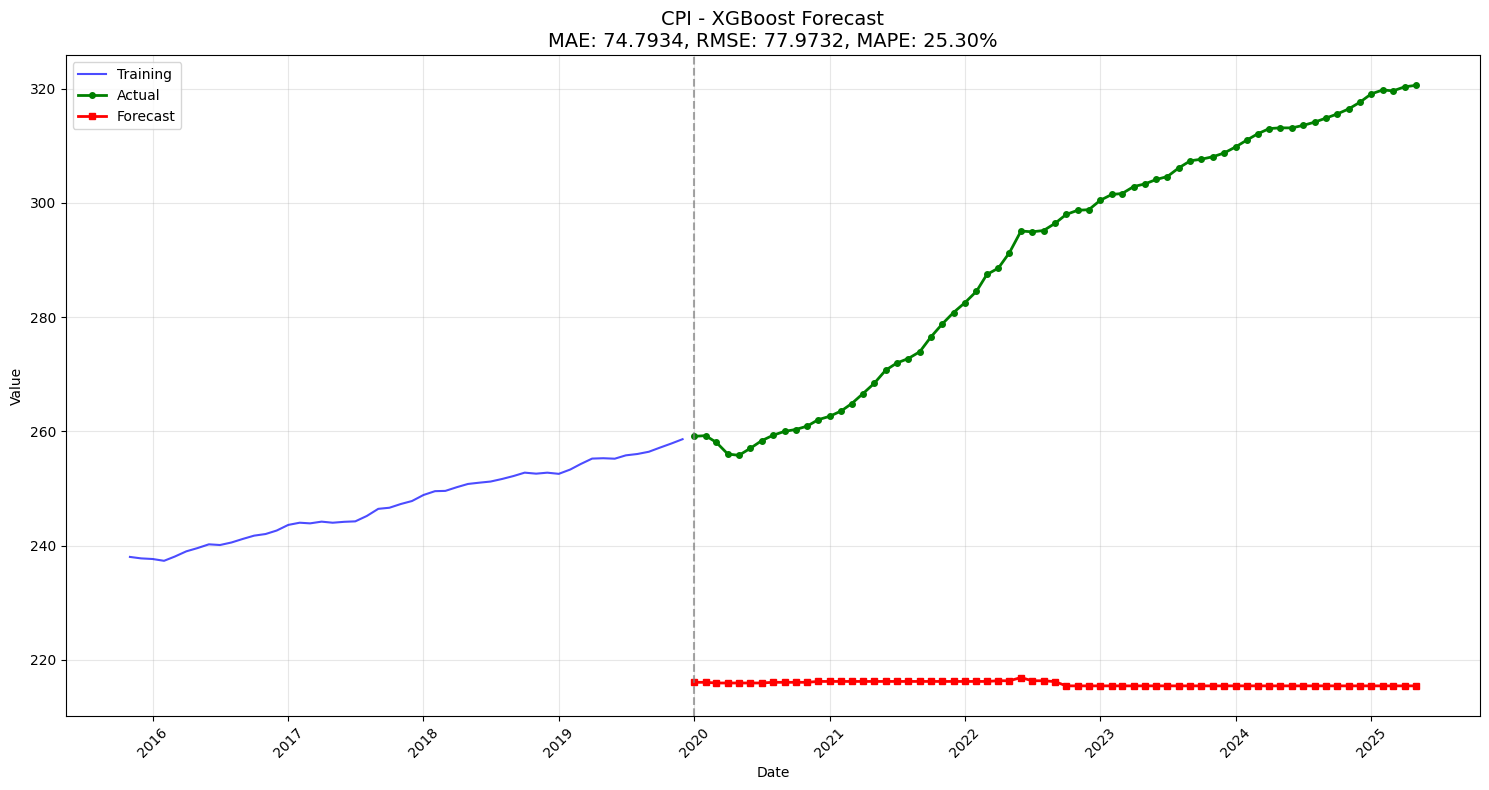

[I 2025-09-16 16:40:42,930] A new study created in memory with name: no-name-18a6caf7-303c-4fe9-b0c9-902875c8ad9f



FORECASTING: INDPRO
Series lengths - Train: 635, Test: 65

Preparing existing features for INDPRO...
Available existing features: 29
Features: ['1_year_rate', '3_months_rate', '6_months_rate', 'CPI', '10_year_rate', 'share_price', 'unemployment_rate', 'PPI', 'OECD_CLI_index', 'CSI_index']...
Cleaning existing feature data...
  Initial shapes - Train: (635, 29), Test: (65, 29)
  Final shapes - Train: (635, 29), Test: (65, 29)
  Features with variation: 29
  Remaining missing values - Train: 0, Test: 0
Clean data shapes - Train: (635, 29), Test: (65, 29)
Using 29 features

Running XGBoost hyperparameter optimization...
Training shape: (508, 29), Validation shape: (127, 29)


[I 2025-09-16 16:40:43,609] Trial 0 finished with value: 1.9408624796536902 and parameters: {'n_estimators': 1656, 'learning_rate': 0.15625485507834141, 'max_depth': 8, 'min_child_weight': 4.971214281012011, 'subsample': 0.8969971843538658, 'colsample_bytree': 0.6194578862605535, 'gamma': 2.9775407112308505, 'reg_alpha': 2.7890432877532283, 'reg_lambda': 2.2043815765490518}. Best is trial 0 with value: 1.9408624796536902.
[I 2025-09-16 16:40:43,801] Trial 1 finished with value: 1.6043358966972878 and parameters: {'n_estimators': 366, 'learning_rate': 0.2258509403141068, 'max_depth': 8, 'min_child_weight': 6.669919534478526, 'subsample': 0.6284826543089377, 'colsample_bytree': 0.805871270423118, 'gamma': 1.0256718502332123, 'reg_alpha': 3.387854912915439, 'reg_lambda': 4.469547321318753}. Best is trial 1 with value: 1.6043358966972878.
[I 2025-09-16 16:40:44,145] Trial 2 finished with value: 1.6816697524014568 and parameters: {'n_estimators': 656, 'learning_rate': 0.03969033294023732, '

Best parameters: {'n_estimators': 393, 'learning_rate': 0.2259617743264958, 'max_depth': 7, 'min_child_weight': 5.609073176717777, 'subsample': 0.7731801343230558, 'colsample_bytree': 0.7869900456739842, 'gamma': 2.672350201039996, 'reg_alpha': 2.954403478362688, 'reg_lambda': 3.197114718421555}
Best validation RMSE: 1.5963
Using validation set for model training

Accuracy Metrics:
  MAE: 2.5923
  RMSE: 3.7591
  MAPE: 2.68%
Model saved to xgb_models/INDPRO_xgb_model.pkl


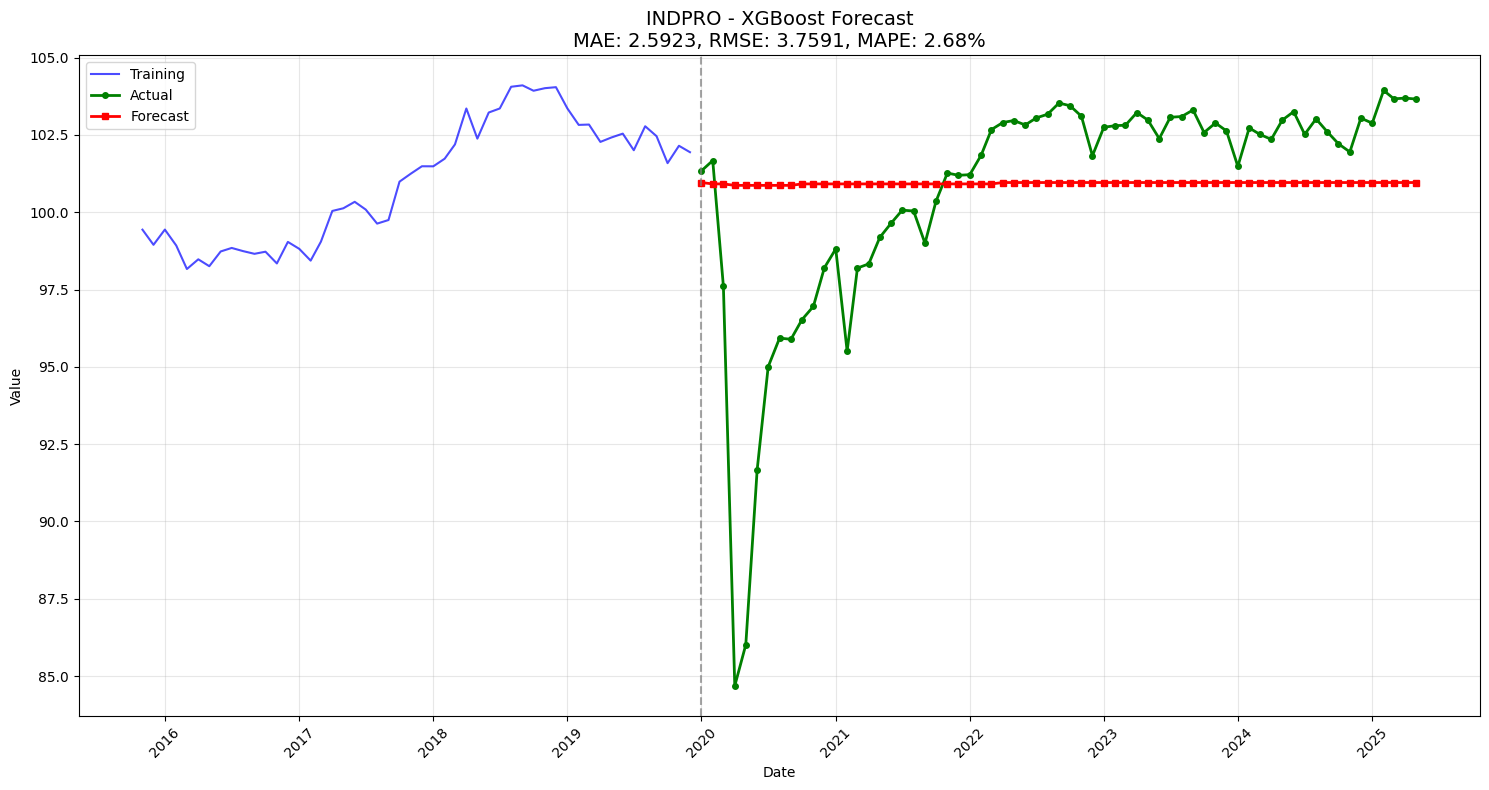

[I 2025-09-16 16:40:58,858] A new study created in memory with name: no-name-f6afee3e-08d4-49cf-b171-692d082893f8



FORECASTING: 10_year_rate
Series lengths - Train: 635, Test: 65

Preparing existing features for 10_year_rate...
Available existing features: 29
Features: ['1_year_rate', '3_months_rate', '6_months_rate', 'CPI', 'INDPRO', 'share_price', 'unemployment_rate', 'PPI', 'OECD_CLI_index', 'CSI_index']...
Cleaning existing feature data...
  Initial shapes - Train: (635, 29), Test: (65, 29)
  Final shapes - Train: (635, 29), Test: (65, 29)
  Features with variation: 29
  Remaining missing values - Train: 0, Test: 0
Clean data shapes - Train: (635, 29), Test: (65, 29)
Using 29 features

Running XGBoost hyperparameter optimization...
Training shape: (508, 29), Validation shape: (127, 29)


[I 2025-09-16 16:40:59,086] Trial 0 finished with value: 1.8368352273960158 and parameters: {'n_estimators': 268, 'learning_rate': 0.025122026799592696, 'max_depth': 3, 'min_child_weight': 3.3430939277952536, 'subsample': 0.6541452699646413, 'colsample_bytree': 0.6450034422143697, 'gamma': 4.554562401962216, 'reg_alpha': 4.069010213015467, 'reg_lambda': 1.7365587573173857}. Best is trial 0 with value: 1.8368352273960158.
[I 2025-09-16 16:40:59,408] Trial 1 finished with value: 1.7392946101308047 and parameters: {'n_estimators': 738, 'learning_rate': 0.19102194593434743, 'max_depth': 5, 'min_child_weight': 8.710132613884873, 'subsample': 0.9413976693127162, 'colsample_bytree': 0.9620148079129339, 'gamma': 4.245771140759869, 'reg_alpha': 4.322431645082817, 'reg_lambda': 2.973215307475955}. Best is trial 1 with value: 1.7392946101308047.
[I 2025-09-16 16:40:59,675] Trial 2 finished with value: 1.4047902941223818 and parameters: {'n_estimators': 604, 'learning_rate': 0.15709031991704273, '

Best parameters: {'n_estimators': 906, 'learning_rate': 0.02982126920943996, 'max_depth': 5, 'min_child_weight': 2.7147723208974552, 'subsample': 0.7218077754928174, 'colsample_bytree': 0.8954823362282471, 'gamma': 0.027176414060370746, 'reg_alpha': 0.5810509084427569, 'reg_lambda': 0.5880528036828472}
Best validation RMSE: 1.2854
Using validation set for model training

Accuracy Metrics:
  MAE: 1.1875
  RMSE: 1.5108
  MAPE: 95.07%
Model saved to xgb_models/10_year_rate_xgb_model.pkl


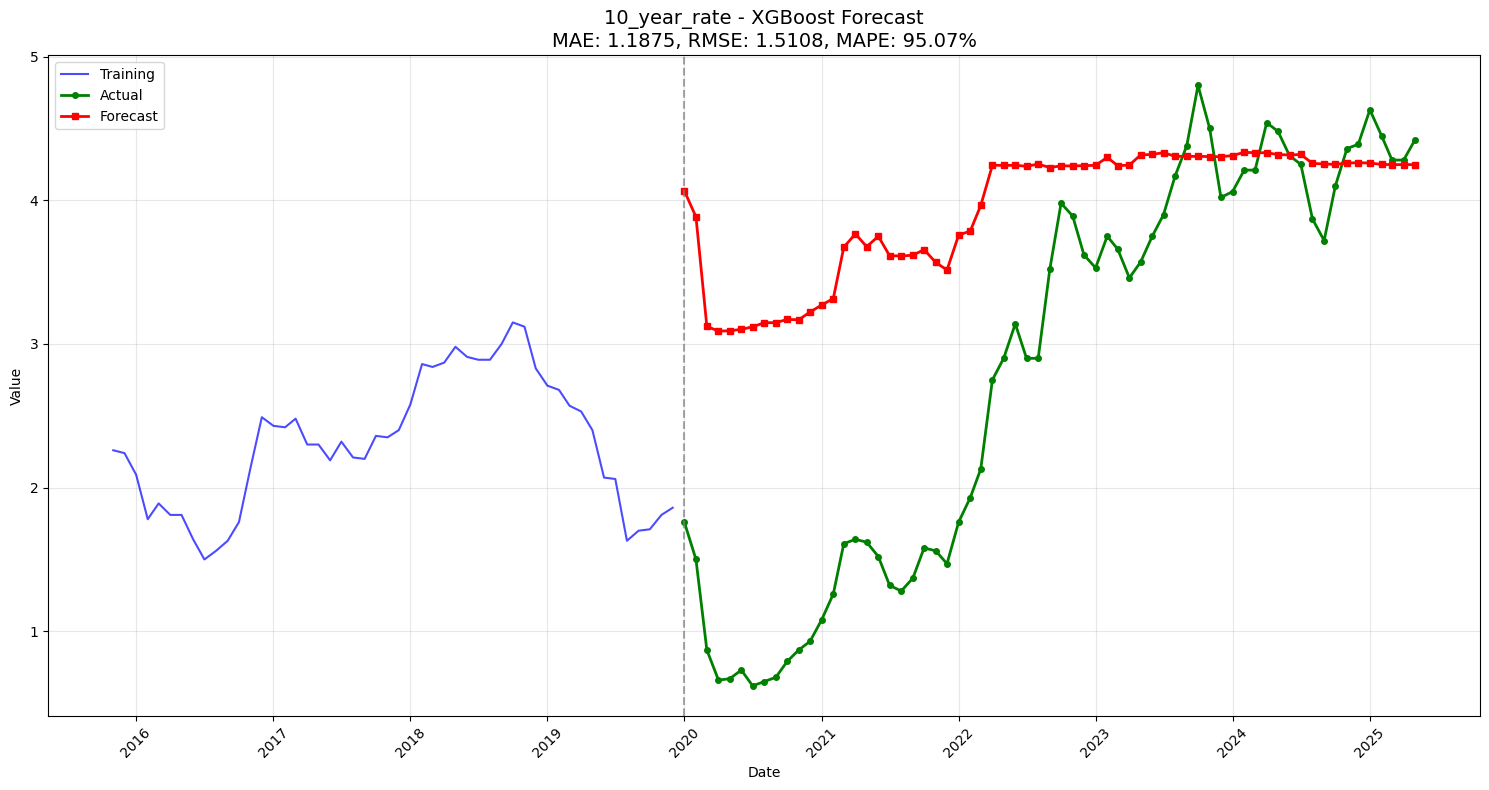

[I 2025-09-16 16:41:21,432] A new study created in memory with name: no-name-040b8abb-c5ce-4b35-bb0b-d646c078a3a2



FORECASTING: share_price
Series lengths - Train: 635, Test: 65

Preparing existing features for share_price...
Available existing features: 29
Features: ['1_year_rate', '3_months_rate', '6_months_rate', 'CPI', 'INDPRO', '10_year_rate', 'unemployment_rate', 'PPI', 'OECD_CLI_index', 'CSI_index']...
Cleaning existing feature data...
  Initial shapes - Train: (635, 29), Test: (65, 29)
  Final shapes - Train: (635, 29), Test: (65, 29)
  Features with variation: 29
  Remaining missing values - Train: 0, Test: 0
Clean data shapes - Train: (635, 29), Test: (65, 29)
Using 29 features

Running XGBoost hyperparameter optimization...
Training shape: (508, 29), Validation shape: (127, 29)


[I 2025-09-16 16:41:22,005] Trial 0 finished with value: 17.178698203329997 and parameters: {'n_estimators': 1297, 'learning_rate': 0.19089546627677595, 'max_depth': 7, 'min_child_weight': 3.9480676961846646, 'subsample': 0.9741789353797826, 'colsample_bytree': 0.9413681322589629, 'gamma': 4.7908760576603555, 'reg_alpha': 4.056514557916007, 'reg_lambda': 3.5188049478901666}. Best is trial 0 with value: 17.178698203329997.
[I 2025-09-16 16:41:22,811] Trial 1 finished with value: 16.71070427076522 and parameters: {'n_estimators': 1160, 'learning_rate': 0.028770648418111243, 'max_depth': 8, 'min_child_weight': 3.8141858667528368, 'subsample': 0.9011009289492091, 'colsample_bytree': 0.851900324037483, 'gamma': 2.172413001080407, 'reg_alpha': 1.613675503700414, 'reg_lambda': 3.6598331604202645}. Best is trial 1 with value: 16.71070427076522.
[I 2025-09-16 16:41:22,957] Trial 2 finished with value: 16.747479788762604 and parameters: {'n_estimators': 232, 'learning_rate': 0.23745230737252643,

Best parameters: {'n_estimators': 850, 'learning_rate': 0.24678254930735571, 'max_depth': 4, 'min_child_weight': 3.9289719759596613, 'subsample': 0.8132140610868873, 'colsample_bytree': 0.9188304646053399, 'gamma': 1.6308737127574369, 'reg_alpha': 2.41553100590659, 'reg_lambda': 2.0737685257706238}
Best validation RMSE: 16.0203
Using validation set for model training

Accuracy Metrics:
  MAE: 60.5151
  RMSE: 63.0355
  MAPE: 39.56%
Model saved to xgb_models/share_price_xgb_model.pkl


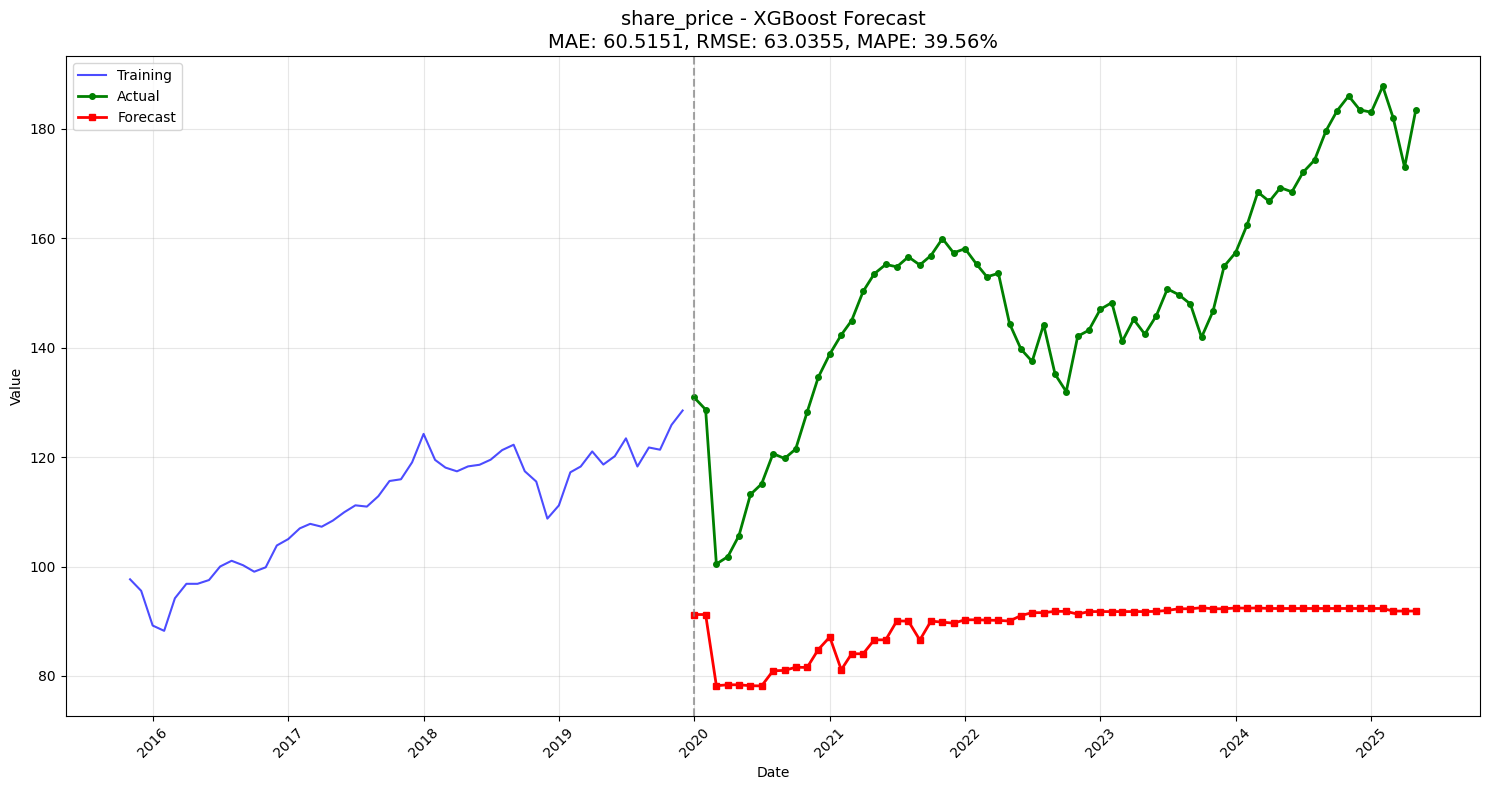

[I 2025-09-16 16:41:44,689] A new study created in memory with name: no-name-0c13eb88-848a-4853-948b-18887328ac15



FORECASTING: unemployment_rate
Series lengths - Train: 635, Test: 65

Preparing existing features for unemployment_rate...
Available existing features: 29
Features: ['1_year_rate', '3_months_rate', '6_months_rate', 'CPI', 'INDPRO', '10_year_rate', 'share_price', 'PPI', 'OECD_CLI_index', 'CSI_index']...
Cleaning existing feature data...
  Initial shapes - Train: (635, 29), Test: (65, 29)
  Final shapes - Train: (635, 29), Test: (65, 29)
  Features with variation: 29
  Remaining missing values - Train: 0, Test: 0
Clean data shapes - Train: (635, 29), Test: (65, 29)
Using 29 features

Running XGBoost hyperparameter optimization...
Training shape: (508, 29), Validation shape: (127, 29)


[I 2025-09-16 16:41:45,097] Trial 0 finished with value: 0.4504760824440594 and parameters: {'n_estimators': 1016, 'learning_rate': 0.05237881839525006, 'max_depth': 6, 'min_child_weight': 2.329848400094504, 'subsample': 0.9792206440931176, 'colsample_bytree': 0.8327594323259719, 'gamma': 0.763450058260533, 'reg_alpha': 2.7074465170535618, 'reg_lambda': 0.529069790335289}. Best is trial 0 with value: 0.4504760824440594.
[I 2025-09-16 16:41:45,969] Trial 1 finished with value: 0.5637863085640931 and parameters: {'n_estimators': 1813, 'learning_rate': 0.013030594565431783, 'max_depth': 3, 'min_child_weight': 8.027147624138156, 'subsample': 0.9117890413234071, 'colsample_bytree': 0.7052686477659142, 'gamma': 2.640939647166483, 'reg_alpha': 0.503755535112787, 'reg_lambda': 3.2151656988487356}. Best is trial 0 with value: 0.4504760824440594.
[I 2025-09-16 16:41:46,462] Trial 2 finished with value: 0.44607366086560374 and parameters: {'n_estimators': 849, 'learning_rate': 0.01119053593521998

Best parameters: {'n_estimators': 1923, 'learning_rate': 0.027821132616692286, 'max_depth': 2, 'min_child_weight': 9.814956915833674, 'subsample': 0.8625467680229326, 'colsample_bytree': 0.9993667663831829, 'gamma': 0.07091608026934816, 'reg_alpha': 0.08721976014188902, 'reg_lambda': 4.914762969639126}
Best validation RMSE: 0.1498
Using validation set for model training

Accuracy Metrics:
  MAE: 1.2472
  RMSE: 2.4698
  MAPE: 17.23%
Model saved to xgb_models/unemployment_rate_xgb_model.pkl


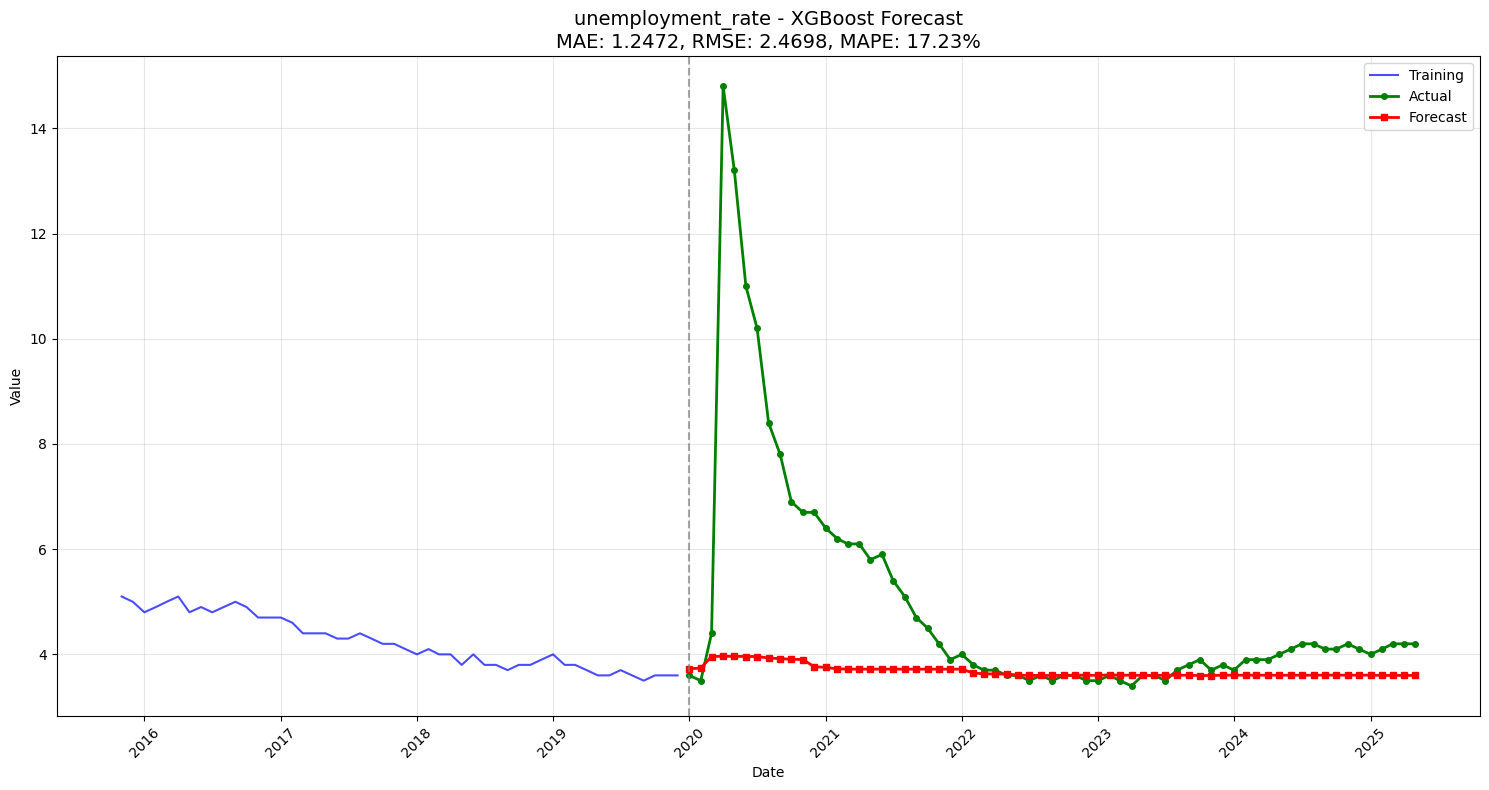

[I 2025-09-16 16:42:12,133] A new study created in memory with name: no-name-d66da1fa-26e8-40be-9787-2e473686fb87



FORECASTING: PPI
Series lengths - Train: 635, Test: 65

Preparing existing features for PPI...
Available existing features: 29
Features: ['1_year_rate', '3_months_rate', '6_months_rate', 'CPI', 'INDPRO', '10_year_rate', 'share_price', 'unemployment_rate', 'OECD_CLI_index', 'CSI_index']...
Cleaning existing feature data...
  Initial shapes - Train: (635, 29), Test: (65, 29)
  Final shapes - Train: (635, 29), Test: (65, 29)
  Features with variation: 29
  Remaining missing values - Train: 0, Test: 0
Clean data shapes - Train: (635, 29), Test: (65, 29)
Using 29 features

Running XGBoost hyperparameter optimization...
Training shape: (508, 29), Validation shape: (127, 29)


[I 2025-09-16 16:42:12,997] Trial 0 finished with value: 25.026248958722462 and parameters: {'n_estimators': 1380, 'learning_rate': 0.07450243010021126, 'max_depth': 2, 'min_child_weight': 9.202094076637485, 'subsample': 0.7615937911733228, 'colsample_bytree': 0.9556663742240838, 'gamma': 1.9829583215903779, 'reg_alpha': 2.3661853718666492, 'reg_lambda': 1.697431192210215}. Best is trial 0 with value: 25.026248958722462.
[I 2025-09-16 16:42:13,627] Trial 1 finished with value: 21.105464550830046 and parameters: {'n_estimators': 1280, 'learning_rate': 0.083502835632946, 'max_depth': 4, 'min_child_weight': 1.3759365153260794, 'subsample': 0.9206232919999907, 'colsample_bytree': 0.7278494498350567, 'gamma': 3.539010679777058, 'reg_alpha': 0.12660917454794862, 'reg_lambda': 3.642866713124859}. Best is trial 1 with value: 21.105464550830046.
[I 2025-09-16 16:42:15,137] Trial 2 finished with value: 20.499907917291132 and parameters: {'n_estimators': 2000, 'learning_rate': 0.01125330181944031

Best parameters: {'n_estimators': 1939, 'learning_rate': 0.2694595977881032, 'max_depth': 6, 'min_child_weight': 2.2042217997366502, 'subsample': 0.9682674074164472, 'colsample_bytree': 0.7982245671404349, 'gamma': 2.2638995293055704, 'reg_alpha': 0.6304313438442627, 'reg_lambda': 1.910784679559594}
Best validation RMSE: 18.7608
Using validation set for model training

Accuracy Metrics:
  MAE: 166.0337
  RMSE: 191.3939
  MAPE: 31.70%
Model saved to xgb_models/PPI_xgb_model.pkl


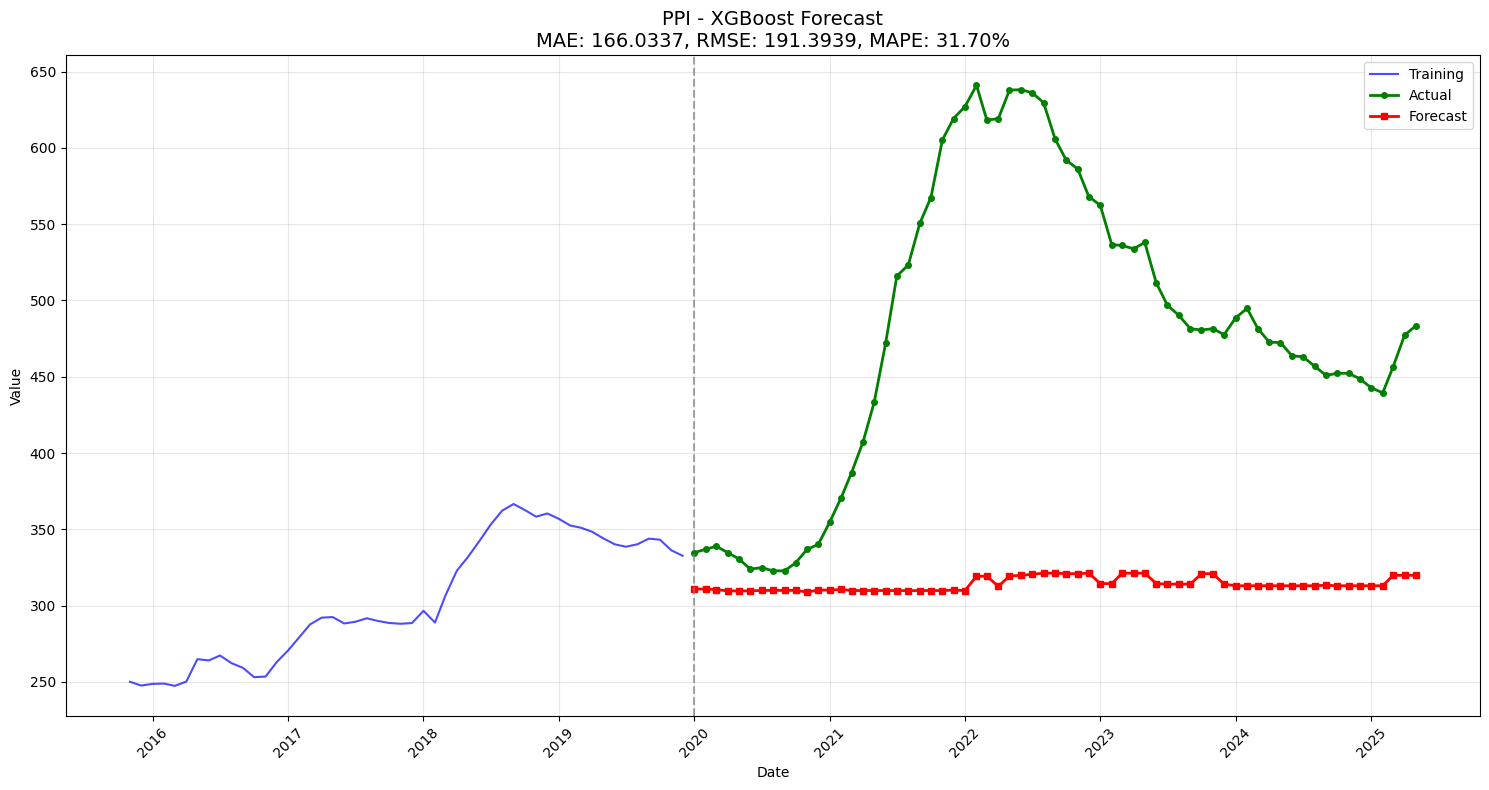

[I 2025-09-16 16:42:54,687] A new study created in memory with name: no-name-9b7e2d3d-34d0-4939-bc46-920046855c56



FORECASTING: OECD_CLI_index
Series lengths - Train: 635, Test: 65

Preparing existing features for OECD_CLI_index...
Available existing features: 29
Features: ['1_year_rate', '3_months_rate', '6_months_rate', 'CPI', 'INDPRO', '10_year_rate', 'share_price', 'unemployment_rate', 'PPI', 'CSI_index']...
Cleaning existing feature data...
  Initial shapes - Train: (635, 29), Test: (65, 29)
  Final shapes - Train: (635, 29), Test: (65, 29)
  Features with variation: 29
  Remaining missing values - Train: 0, Test: 0
Clean data shapes - Train: (635, 29), Test: (65, 29)
Using 29 features

Running XGBoost hyperparameter optimization...
Training shape: (508, 29), Validation shape: (127, 29)


[I 2025-09-16 16:42:55,041] Trial 0 finished with value: 0.13662444174007682 and parameters: {'n_estimators': 803, 'learning_rate': 0.20469856864050665, 'max_depth': 3, 'min_child_weight': 4.490812060125576, 'subsample': 0.6582604967679602, 'colsample_bytree': 0.9606207867122325, 'gamma': 2.9353628242890317, 'reg_alpha': 2.9961303772893464, 'reg_lambda': 3.0438706504740067}. Best is trial 0 with value: 0.13662444174007682.
[I 2025-09-16 16:42:55,482] Trial 1 finished with value: 0.17350470708890242 and parameters: {'n_estimators': 1118, 'learning_rate': 0.07120596611430698, 'max_depth': 6, 'min_child_weight': 9.024539238770657, 'subsample': 0.6330199457707592, 'colsample_bytree': 0.8379389205590884, 'gamma': 1.824810977659776, 'reg_alpha': 2.0787690938037624, 'reg_lambda': 1.214713569401402}. Best is trial 0 with value: 0.13662444174007682.
[I 2025-09-16 16:42:56,022] Trial 2 finished with value: 0.17190484915077742 and parameters: {'n_estimators': 1182, 'learning_rate': 0.018908747029

Best parameters: {'n_estimators': 321, 'learning_rate': 0.08561068766515594, 'max_depth': 8, 'min_child_weight': 3.833489284737251, 'subsample': 0.7464870260795613, 'colsample_bytree': 0.9982623013622429, 'gamma': 0.5939236610373404, 'reg_alpha': 4.515211840708062, 'reg_lambda': 4.5624311861464175}
Best validation RMSE: 0.1035
Using validation set for model training

Accuracy Metrics:
  MAE: 0.7982
  RMSE: 1.2179
  MAPE: 0.81%
Model saved to xgb_models/OECD_CLI_index_xgb_model.pkl


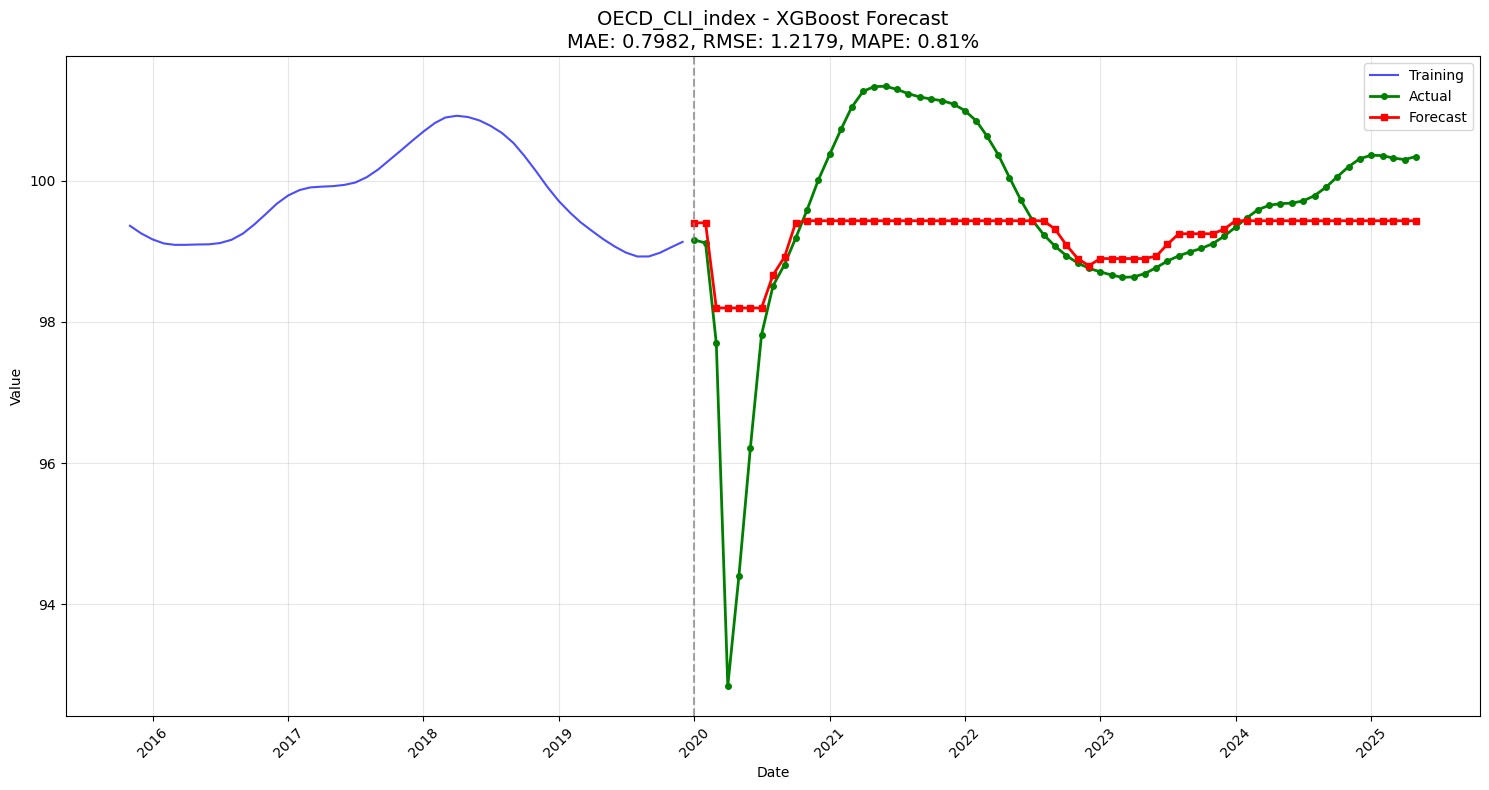

[I 2025-09-16 16:43:09,608] A new study created in memory with name: no-name-1640200f-410b-4ef2-8d32-c8da81dae283



FORECASTING: CSI_index
Series lengths - Train: 635, Test: 65

Preparing existing features for CSI_index...
Available existing features: 29
Features: ['1_year_rate', '3_months_rate', '6_months_rate', 'CPI', 'INDPRO', '10_year_rate', 'share_price', 'unemployment_rate', 'PPI', 'OECD_CLI_index']...
Cleaning existing feature data...
  Initial shapes - Train: (635, 29), Test: (65, 29)
  Final shapes - Train: (635, 29), Test: (65, 29)
  Features with variation: 29
  Remaining missing values - Train: 0, Test: 0
Clean data shapes - Train: (635, 29), Test: (65, 29)
Using 29 features

Running XGBoost hyperparameter optimization...
Training shape: (508, 29), Validation shape: (127, 29)


[I 2025-09-16 16:43:10,062] Trial 0 finished with value: 4.793112951218315 and parameters: {'n_estimators': 457, 'learning_rate': 0.012760077065594776, 'max_depth': 3, 'min_child_weight': 5.072655331692513, 'subsample': 0.8534364944008727, 'colsample_bytree': 0.7558509301512206, 'gamma': 3.1325131245697317, 'reg_alpha': 4.3166073401305445, 'reg_lambda': 4.5368464098593195}. Best is trial 0 with value: 4.793112951218315.
[I 2025-09-16 16:43:13,837] Trial 1 finished with value: 5.578799420776013 and parameters: {'n_estimators': 1930, 'learning_rate': 0.012622069315574792, 'max_depth': 8, 'min_child_weight': 8.602825741991609, 'subsample': 0.6294559992690617, 'colsample_bytree': 0.6399682699956079, 'gamma': 1.1238846446183897, 'reg_alpha': 1.9170230679029165, 'reg_lambda': 4.45633793703653}. Best is trial 0 with value: 4.793112951218315.
[I 2025-09-16 16:43:14,707] Trial 2 finished with value: 5.356519570018691 and parameters: {'n_estimators': 1463, 'learning_rate': 0.16270734301044504, '

Best parameters: {'n_estimators': 240, 'learning_rate': 0.029193872972282882, 'max_depth': 2, 'min_child_weight': 2.9920942964427257, 'subsample': 0.6054019162548179, 'colsample_bytree': 0.9877991644256312, 'gamma': 1.731959430978205, 'reg_alpha': 1.3093443861076717, 'reg_lambda': 0.5340934417528135}
Best validation RMSE: 3.5104
Using validation set for model training

Accuracy Metrics:
  MAE: 24.2600
  RMSE: 26.2382
  MAPE: 37.40%
Model saved to xgb_models/CSI_index_xgb_model.pkl


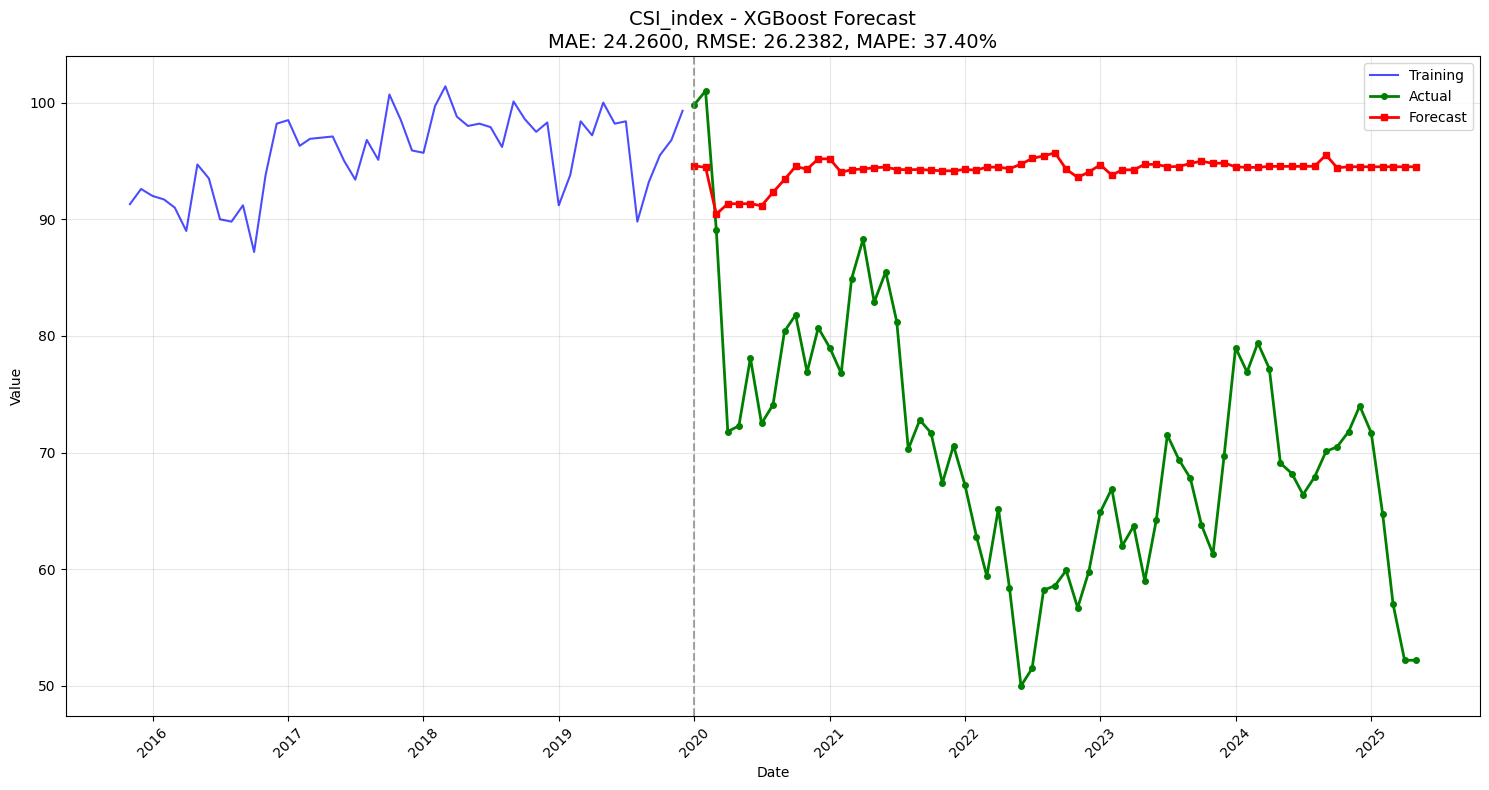

[I 2025-09-16 16:43:37,780] A new study created in memory with name: no-name-bb24e758-f361-47df-b710-e94975a33950



FORECASTING: gdp_per_capita
Series lengths - Train: 635, Test: 64

Preparing existing features for gdp_per_capita...
Available existing features: 29
Features: ['1_year_rate', '3_months_rate', '6_months_rate', 'CPI', 'INDPRO', '10_year_rate', 'share_price', 'unemployment_rate', 'PPI', 'OECD_CLI_index']...
Cleaning existing feature data...
  Initial shapes - Train: (635, 29), Test: (65, 29)
  Final shapes - Train: (635, 29), Test: (65, 29)
  Features with variation: 29
  Remaining missing values - Train: 0, Test: 0
Clean data shapes - Train: (635, 29), Test: (64, 29)
Using 29 features

Running XGBoost hyperparameter optimization...
Training shape: (508, 29), Validation shape: (127, 29)


[I 2025-09-16 16:43:38,813] Trial 0 finished with value: 3597.3737147397483 and parameters: {'n_estimators': 925, 'learning_rate': 0.07887156177055593, 'max_depth': 3, 'min_child_weight': 5.741070548880135, 'subsample': 0.8998492405048379, 'colsample_bytree': 0.9480869028873504, 'gamma': 1.799562973093033, 'reg_alpha': 4.730164951303314, 'reg_lambda': 2.4477289437796683}. Best is trial 0 with value: 3597.3737147397483.
[I 2025-09-16 16:43:39,115] Trial 1 finished with value: 3593.737135872311 and parameters: {'n_estimators': 281, 'learning_rate': 0.025857760677461174, 'max_depth': 3, 'min_child_weight': 7.905484524715241, 'subsample': 0.9852177555258665, 'colsample_bytree': 0.7515775254468844, 'gamma': 1.319331912310067, 'reg_alpha': 4.930661786935299, 'reg_lambda': 2.982114704313676}. Best is trial 1 with value: 3593.737135872311.
[I 2025-09-16 16:43:39,891] Trial 2 finished with value: 3589.267671170796 and parameters: {'n_estimators': 961, 'learning_rate': 0.2982655655350458, 'max_d

Best parameters: {'n_estimators': 547, 'learning_rate': 0.08253672432285881, 'max_depth': 7, 'min_child_weight': 5.080953512055034, 'subsample': 0.6894450523559267, 'colsample_bytree': 0.6215081820111461, 'gamma': 3.132546023617656, 'reg_alpha': 2.8491582540850056, 'reg_lambda': 2.3641009126729475}
Best validation RMSE: 3532.3880
Using validation set for model training

Accuracy Metrics:
  MAE: 10245.0073
  RMSE: 10583.9332
  MAPE: 15.42%
Model saved to xgb_models/gdp_per_capita_xgb_model.pkl


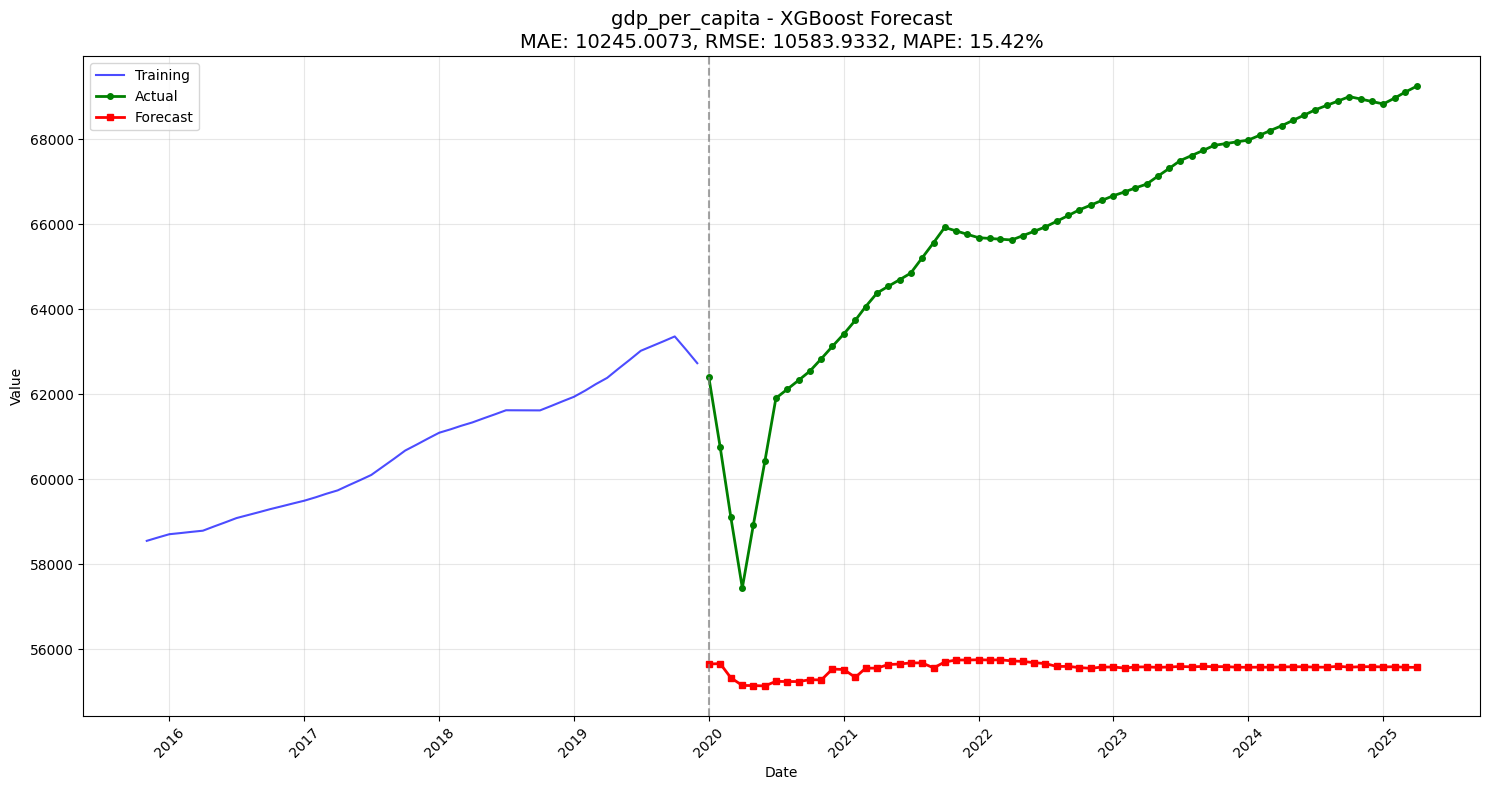


FORECASTING COMPLETE
Successfully forecasted 12 indicators

SUMMARY METRICS:
1_year_rate          - MAE: 0.5789, RMSE: 0.6289, MAPE: 157.60%
3_months_rate        - MAE: 0.3745, RMSE: 0.4358, MAPE: 430.98%
6_months_rate        - MAE: 0.6267, RMSE: 0.6885, MAPE: 439.13%
CPI                  - MAE: 74.7934, RMSE: 77.9732, MAPE: 25.30%
INDPRO               - MAE: 2.5923, RMSE: 3.7591, MAPE: 2.68%
10_year_rate         - MAE: 1.1875, RMSE: 1.5108, MAPE: 95.07%
share_price          - MAE: 60.5151, RMSE: 63.0355, MAPE: 39.56%
unemployment_rate    - MAE: 1.2472, RMSE: 2.4698, MAPE: 17.23%
PPI                  - MAE: 166.0337, RMSE: 191.3939, MAPE: 31.70%
OECD_CLI_index       - MAE: 0.7982, RMSE: 1.2179, MAPE: 0.81%
CSI_index            - MAE: 24.2600, RMSE: 26.2382, MAPE: 37.40%
gdp_per_capita       - MAE: 10245.0073, RMSE: 10583.9332, MAPE: 15.42%


In [6]:
# Example usage:
# Load your data with train/test split
train_df = pd.read_csv('../data/fix/feature_selected_recession_train.csv')
test_df = pd.read_csv('../data/fix/feature_selected_recession_test.csv')

results, forecasts = run_xgb_forecasting_existing_features(
    train_df, test_df,
    financial_indicators=financial_indicators,
    n_trials=40,
    plot_results=True
)